In [1]:
from constraints import *
from helper import *

# Polynomial System

Made-up polynomial (discretized) dynamics:

$x_{t+1} = x_t^3 y_t^2\Delta_t + x_t$         
$y_{t+1} = -x_t y_t\Delta_t + y_t$

### Forward Euler

In [2]:
def forwardEulerPoly(init,constants,plot=False):
    x0, y0 = init[0], init[1]
    
    T = constants["T"]
    del_t = constants["del_t"]
    
    xs, ys = [x0], [y0]
    x,y = x0, y0
    for t in range(T):
        x, y = (x**3)*(y**2)*del_t + x, -1*x*y*del_t + y
        xs.append(x)
        ys.append(y)
        
#     if plot:
#         plt.figure()
#         plt.plot(xs, ys, '*')
        
    traj = [(xs[i],ys[i]) for i in range(len(xs))]
    return traj

### Initial Setup

In [3]:
# horizon and forward Euler time step
T = 6
del_t = 0.1

# box constraints for initial state
x0 = 1
y0 = 1
x_dev = 0.01
y_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0

# constants for dynamics
constants = {"T":T, "del_t":del_t,
             "x0":x0, "y0":y0}

x_range, y_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev]

useConvex = True

### Fast Reachable Set Computation

In [4]:
areas_fast = []
times_fast = []
boxes_fast = []

x0_bounds = BoxConstraints(x_lw_b,x_up_b)
y0_bounds = BoxConstraints(y_lw_b,y_up_b)

var_bounds = {"x":x0_bounds, "y":y0_bounds}

x_0_coeffs = {"x":1, "y":0, "_const":0}
x_0 = LinearConstraints(Line(x_0_coeffs.copy()), Line(x_0_coeffs.copy()),var_bounds)

y_0_coeffs = {"x":0, "y":1, "_const":0}
y_0 = LinearConstraints(Line(y_0_coeffs.copy()), Line(y_0_coeffs.copy()),var_bounds)

for t in range(constants["T"]):
    tt = time.time()
    box_x, box_y = x_0.eval_box(), y_0.eval_box()
    areas_fast.append((box_x.upper-box_x.lower)*(box_y.upper-box_y.lower))
    boxes_fast.append(([box_x.lower,box_x.upper],[box_y.lower,box_y.upper]))
    
    x_temp = x_0.power(d=3,convex=useConvex).mult(y_0.power(d=2,convex=useConvex)).mult_const(constants["del_t"]).add(x_0)
    y_temp = x_0.mult(y_0).mult_const(-1*constants["del_t"]).add(y_0)
    x_0, y_0 = x_temp, y_temp
    
    tt = time.time() - tt
    times_fast.append(tt)

### CVX Reachable Set Computation

In [5]:
def PolyConstraints(T=1,variables=[],constraints=[],control_bounds=[],Npast=0, use_convex=False, constants={}):
    times = []
    ss = []
    boxes = []
    del_t = constants["del_t"]
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)
        xL,xU = x_bounds
        yL,yU = y_bounds
        boxes.append(([xL,xU],[yL,yU]))
        ss.append((xU-xL)*(yU-yL))
        
        # x^2
        x2 = variables[t]["x2"]
        constraints.extend(McCormick(x2,x,x,x_bounds,x_bounds))
        x2_bounds = bounds(x2,constraints,Npast=Npast)
        
        # x^3
        x3 = variables[t]["x3"]
        constraints.extend(McCormick(x3,x2,x,x2_bounds,x_bounds))
        x3_bounds = bounds(x3,constraints,Npast=Npast)
        
        # y^2
        y2 = variables[t]["y2"]
        constraints.extend(McCormick(y2,y,y,y_bounds,y_bounds))
        y2_bounds = bounds(y2,constraints,Npast=Npast)
        
        # x^3 y^2
        x3y2 = variables[t]["x3y2"]
        constraints.extend(McCormick(x3y2,x3,y2,x3_bounds,y2_bounds))
        x3y2_bounds = bounds(x3y2,constraints,Npast=Npast)
        
        # xy
        xy = variables[t]["xy"]
        constraints.extend(McCormick(xy,x,y,x_bounds,y_bounds))
        
        x_new = variables[t+1]["x"]
        constraints.append(x_new == x3y2*del_t + x)
        
        y_new = variables[t+1]["y"]
        constraints.append(y_new == -1*xy*del_t + y)

        tt = time.time() - tt
        times.append(tt)
    
    return variables,constraints, times, ss,boxes

In [7]:
variables = [{"x":cvxpy.Variable(),"y":cvxpy.Variable(),"x2":cvxpy.Variable(),"x3":cvxpy.Variable(),"y2":cvxpy.Variable(),"x3y2":cvxpy.Variable(),"xy":cvxpy.Variable()} for t in range(T+1)]

# plt.figure(2)
# plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

x = variables[0]["x"]
y = variables[0]["y"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)

variables,constraints,times_convex,areas_convex,boxes_convex = PolyConstraints(T,variables,constraints,control_bounds=[],use_convex=False,constants=constants)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)

Academic license - for non-commercial use only


### Visualizations

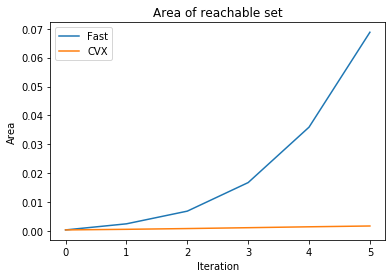

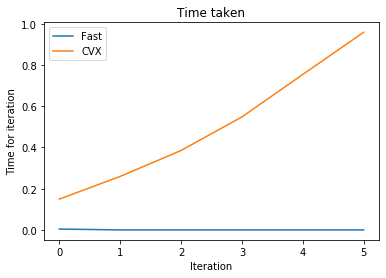

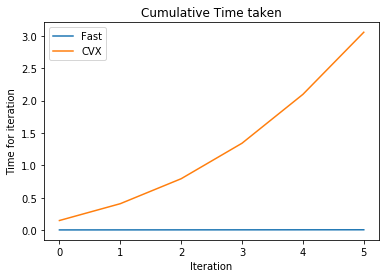

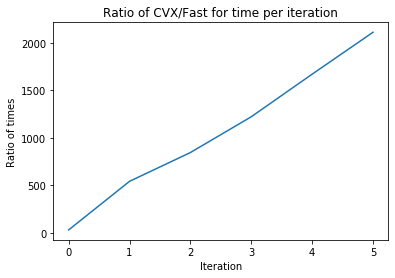

In [8]:
convex_res = {"area":areas_convex, "time":times_convex}
fast_res = {"area":areas_fast, "time":times_fast}
visualize(convex_res,fast_res)

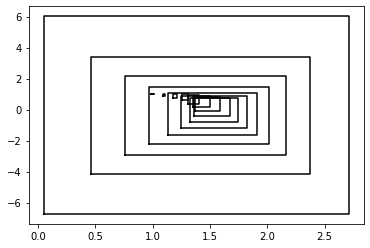

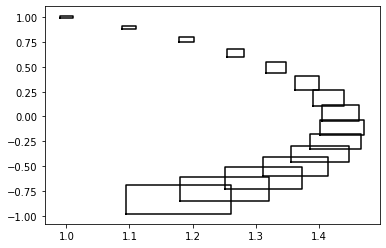

In [17]:
plot_boxes_2d(boxes_fast)
plot_boxes_2d(boxes_convex)

### Verify Boxes Found are Valid via Sampling

Sample the space of initial conditions and forward propogate trajectories using the forward Euler method to validate if trajectories remain within boxed sets found via both the CVX approach or the fast approach.

NOTE: Forward euler assumes constant control at $u_t \equiv 1$. Should change in the future.

True
True


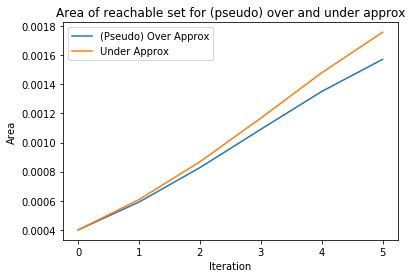

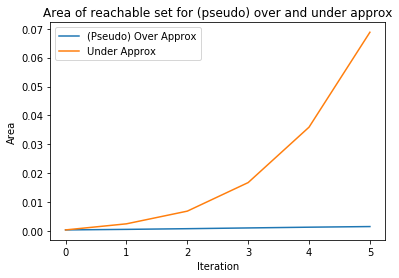

In [9]:
num_samples = 10000
print(verify_valid_boxes(boxes_convex,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerPoly,constants=constants))
print(verify_valid_boxes(boxes_fast,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerPoly,constants=constants))